In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f, norm, chi2
import time
import math

from FunctionsFile import Rx, Ry, Rz, Xi, kmle, F, Dnminus, Dnplus, Dn, Me, F2, MV, Mn

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from GenerateFisherDistribution import FisherDistribution2, FisherDistribution

In [2]:
df = pd.read_csv('/Users/nikitazabolotniy/Desktop/FWDmodel/GRP_data_list.csv')
df2 = pd.read_csv('/Users/nikitazabolotniy/Desktop/FWDmodel/GRP_data_list_2.csv')
p = 3
a = df[df.loc[:,'Sex'] == 'F']
b = df[df.loc[:,'Sex'] == 'M']
a1 = a.loc[:,'Insect'].unique().tolist()
b1 = b.loc[:,'Insect'].unique().tolist()
uniq = [a for a in a1 if a in b1]
insects_list = list(set(a1 + b1))

# those critical values reject fisherness at 10,5,1 % confidence respectively
Me_crit = [0.99, 1.094, 1.308]
Mu_crit = [1.138, 1.207, 1.347]
Mn_crit = [0.819, 0.895, 1.035]
critical_vals = np.array([Me_crit, Mu_crit, Mn_crit])

In [3]:
def get_insect_cell_rot(df, insect="Hermetia-illucens", cell='H1'):
    df_female_rot = df[(df.loc[:,'Cell'] == cell) & (df.loc[:,'Sex'] == "F") & 
                    (df.loc[:,'Insect'] == insect)]
    df_male_rot = df[(df.loc[:,'Cell'] == cell) & (df.loc[:,'Sex'] == "M") & 
                    (df.loc[:,'Insect'] == insect)]
    df_female_rot = df_female_rot.loc[:, ['azi_rot', 'ele_rot']]
    df_male_rot = df_male_rot.loc[:, ['azi_rot', 'ele_rot']]
    return df_female_rot, df_male_rot


def get_insect_cell_rot_2(df, insect, sex, cell='H1'):
    df_rot = df[(df.loc[:,'Cell'] == cell) & (df.loc[:,'Sex'] == sex) & 
                    (df.loc[:,'Insect'] == insect)]
    df_rot = df_rot.loc[:, ['azi_rot', 'ele_rot']]
    return df_rot


def transform2spher_coord(*args):
    transformed = {}
    for num, df in enumerate(args):
        # transform positive azimuth values
        df.loc[:,'azi_rot'][df.loc[:,'azi_rot'] > 0] = \
        360 - df.loc[:,'azi_rot'][df.loc[:,'azi_rot'] > 0]
        # transform negative azimuth values
        df.loc[:,'azi_rot'][df.loc[:,'azi_rot'] < 0] = \
        df.loc[:,'azi_rot'][df.loc[:,'azi_rot'] < 0].abs()
        # transform positive elevation values
        df.loc[:,'ele_rot'][df.loc[:,'ele_rot'] > 0] = \
        90 - df.loc[:,'ele_rot'][df.loc[:,'ele_rot'] > 0]
        # transform negative elevation values
        df.loc[:,'ele_rot'][df.loc[:,'ele_rot'] < 0] = \
        df.loc[:,'ele_rot'][df.loc[:,'ele_rot'] < 0].abs() + 90
        transformed[num] = df
    return transformed


def deg2rad_cartesian(g):
    g = g/180*np.pi  # format azimuth elevation (phi, theta)
    g['rotx'] = np.sin(g.iloc[:,1]) * np.cos(g.iloc[:,0])
    g['roty'] = np.sin(g.iloc[:,1]) * np.sin(g.iloc[:,0])
    g['rotz'] = np.cos(g.iloc[:,1])
    g['RotAxes'] = g[['rotx', 'roty', 'rotz']].apply(list, axis=1)
    
    return g


def extract_resl_mresl_2(g1, g2):
    if g1.shape[0] <= 1 or g2.shape[0] <= 1:
        return 1, 1, 1, g1.shape[0], g2.shape[0], 0
    else:
        g = pd.concat([g1, g2],axis=0, join='outer',ignore_index=False, keys=['F','M'])
        cartesian = np.array(g['RotAxes'].tolist()) 
        cartesianF = np.array(g.loc['F']['RotAxes'].tolist())
        cartesianM = np.array(g.loc['M']['RotAxes'].tolist())

        resultant = np.sum(cartesian,axis=0)
        resultantF = np.sum(cartesianF,axis=0)
        resultantM = np.sum(cartesianM,axis=0)

        res_len = np.linalg.norm(resultant)
        res_lenF = np.linalg.norm(resultantF)
        res_lenM = np.linalg.norm(resultantM)
        n1 = g1.shape[0]
        n2 = g2.shape[0]
        n = g.shape[0]
        
        assert n1 + n2 == n, 'sample sizes dont add up to n'
        return res_len, res_lenF, res_lenM, n1, n2, n
    
    
def extract_com_cart(g):
    cartesian = np.array(g['RotAxes'].tolist()) 
    if cartesian.shape[0] == 0:
        centre_of_mass = np.float('nan')
        mean_res_length = np.float('nan')
    else:
        centre_of_mass = np.mean(cartesian,axis=0)
        mean_res_length = np.linalg.norm(centre_of_mass)

    return cartesian, centre_of_mass, mean_res_length
    
    
def convert_coord(centre_of_mass, mean_res_length):
    azi = np.arctan2(centre_of_mass[1], centre_of_mass[0])  # range in [-pi, pi]
    if azi < 0 :
        azi = 2*np.pi + azi
    ele = np.arccos(centre_of_mass[2] / mean_res_length)
    return azi, ele



def high_k_Ftest_mardia(res_len, res_lenF, res_lenM, n):
    # mardia, test for equality of mean directions, assuming concentration parameters are equal
    p = 3 
    # if n = 2 then its either 0 and 2 or 1 and 1 sample for species, no inference can be made
    if n <= 2:
        High_k_Ftest = float('nan')
        fcrit = float('nan')
        dof1, dof2 = 0, 0
    else:
        dof1, dof2 = p-1, (p-1)*(n-2)
        High_k_Ftest = ((res_lenF+res_lenM - res_len)/(p-1))/((n - res_lenF - res_lenM)/((n-2)*(p-1)))
        fcrit = f.ppf(0.95, p-1, (p-1)*(n-2))
    return High_k_Ftest, fcrit, dof1, dof2


def test_equal_k(res_lenF, res_lenM, n1, n2):
    # mardia 10.5.3, for mean res len >= 0.67
    p = 3
    if n1 == 1 or n2 == 1:
        F = float('nan')
        fcrit = float('nan')
        dof1, dof2 = 0, 0
    else:
        F = ((n1 - res_lenF)/((n1-1)*(p-1)))/((n2 - res_lenM)/((n2-1)*(p-1)))
        dof1, dof2 = (n1-1)*(p-1), (n2-1)*(p-1)
        fcrit = f.ppf(0.975, (n1-1)*(p-1), (n2-1)*(p-1))
    return F, fcrit, dof1, dof2


def color_negative_red_2(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: x'`.
    """
    if isinstance(val, tuple):
        color = 'red' if val[0] < 0.05 else 'green'
    else:
        color = 'black'
    return 'color: %s' % color


def color_df(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: x'`.
    """
    if isinstance(val, str):
        if val == 'pval > 0.1':
            color = 'green' 
        elif val == '––':
            color = 'black'
        elif val == '0':
            color = 'black'
        elif val == '0.05 > pval > 0.01':
            color = 'red'
        elif val == '0.1 > pval > 0.05':
            color = 'red'
        elif val == 'pval < 0.01':
            color = 'red'
        else:
            color = 'black'
    elif isinstance(val, tuple):
        if val[0] <= 1:
            color = 'red' if val[0] < 0.05 else 'green'
        else:
            color = 'black'
    else:
        color = 'black'
    return 'color: %s' % color


def get_azi_ele(cartesian, azi=None, ele=None):
    if cartesian.ndim == 1:
        mean_res_length = np.linalg.norm(cartesian)
        azi = np.arctan2(cartesian[1], cartesian[0])  # range in [-pi, pi]
        if azi < 0 :
            azi = 2*np.pi + azi
        if azi == 0:
            azi = 0.001
        ele = np.arccos(cartesian[2] / mean_res_length)
        return azi, ele
    if azi is not None and ele is not None:
        cartesian = cartesian.T
        movedcart = Ry(-ele, Rz(-azi, cartesian))
        movedazi = np.zeros(movedcart.shape[1])
        movedele = np.zeros(movedcart.shape[1])
        movedlen = np.linalg.norm(movedcart,axis=0)
        movedcart = movedcart.T
        
        for i in range(len(movedazi)):
            movedazi[i] = np.arctan2(movedcart[i, 1], movedcart[i, 0])  # range in [-pi, pi]
            movedele[i] = np.arccos(movedcart[i, 2] / movedlen[i])
        movedazi[movedazi < 0] = 2*np.pi + movedazi[movedazi < 0]  # range in [0, 2pi]
        
        return movedazi, movedele, movedcart
    

def Cart2Polar(cartesian):
    '''returns (ele, azi) in range [0, pi] and [-pi, pi]'''
    if type(cartesian) is np.ndarray:
        pass
    else:
        cartesian = np.array(cartesian)
    lengths = np.linalg.norm(cartesian, axis=0)
    if cartesian.ndim == 1:  # this is a single vector
        cartesian = cartesian.reshape(-1,)
        polar = np.zeros(2)
        # when arctan2 is used, it returns the positive direction from positive x to positive y
        # so this is the same positive direction as for [0, 2pi] range
        polar[1] = np.arctan2(cartesian[1], cartesian[0])  # range in [-pi, pi]
        polar[0] = np.arccos(cartesian[2] / lengths)
#         polar[polar < 0] = 2 * np.pi + polar[polar < 0]
    else:
        polar = np.zeros((2, cartesian.shape[1]))
        for i in range(cartesian.shape[1]):
            polar[1,i] = np.arctan2(cartesian[1, i], cartesian[0, i])  # range in [-pi, pi]
            polar[0,i] = np.arccos(cartesian[2, i] / lengths[i])
#         polar[1, :][polar[1, :]<0] = 2 * np.pi + polar[1, :][polar[1, :]<0]
    return polar


def rot_mat(sample, alpha, beta):
    # from GOODNESS-OF-FIT TESTS FOR FISHER’S DISTRIBUTION ON THE SPHERE 1984
    # sample should be a set of column vectors
    cos = np.cos
    sin = np.sin
    tr_mat = np.array([[cos(alpha) * cos(beta), cos(alpha) * sin(beta), -sin(alpha)],
             [-sin(beta), cos(beta), 0],
             [sin(alpha)*cos(beta), sin(alpha)*sin(beta), cos(alpha)]])
    return np.matmul(tr_mat.T, sample).T


def rot_mat_2(sample, alpha, beta):
    # from GOODNESS-OF-FIT TESTS FOR FISHER’S DISTRIBUTION ON THE SPHERE 1984
    # sample should be a set of column vectors
    cos = np.cos
    sin = np.sin
    tr_mat = np.array([[sin(alpha) * cos(beta), sin(alpha) * sin(beta), cos(alpha)],
             [sin(beta), -cos(beta), 0],
             [cos(alpha)*cos(beta), cos(alpha)*sin(beta), -sin(alpha)]])
    return np.matmul(tr_mat.T, sample).T


def gof_tests(movedele, movedazi, movedcart, test):
    n = movedele.shape[0]
    if test == 'Exponentiality':
        Xi1 = Xi(movedele)
        k = kmle(movedele)  # mle for concentration parameter k
        FX = F(k, Xi1)
        # compute the order statistic of  Xi before inputting them to the F function, this is done in the Dn function
        Dplus = Dnplus(FX)
        Dminus = Dnminus(FX)
        Dn1 = Dn(Dplus, Dminus)
        return Me(Dn1, n)
    elif test == 'Uniformity':
        FX2 = F2(movedazi)
        D2plus = Dnplus(FX2)
        D2minus = Dnminus(FX2)
        Vn = D2plus + D2minus
        return MV(Vn, n)
    else:
#         movedcart1 = rot_mat_2(movedcart.T, ele, azi)
        movedazi1, movedele1, movedcart1 = get_azi_ele(movedcart, azi=0, ele=-np.pi/2)
        polar = Cart2Polar(movedcart1.T).T
        Sn = np.array([azi*np.sqrt(ele) for ele,azi in polar])
        std = np.sqrt(sum(Sn**2)/len(Sn))
        Sn_sort = sorted(Sn)
        FSn = norm.cdf(Sn_sort, scale=std)
        Dplus3 = Dnplus(FSn)
        Dminus3 = Dnminus(FSn)
        Dn3 = Dn(Dplus3, Dminus3)
        return Mn(Dn3, n)
    
    
def plot_sph_distr(movedcart):
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:30j, 0.0:2.0*pi:30j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)

    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

    ax.scatter(movedcart[:,0], movedcart[:,1], movedcart[:,2])

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()
    

def plot_sph_distrs(movedcart1, movedcart2):
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:30j, 0.0:2.0*pi:30j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)

    mean1 = np.mean(movedcart1, axis=0)
    mean2 = np.mean(movedcart2, axis=0)
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

    ax.scatter(movedcart1[:,0], movedcart1[:,1], movedcart1[:,2], color='blue')
    ax.scatter(mean1[0], mean1[1], mean1[2], marker='^', color='blue')
    ax.scatter(movedcart2[:,0], movedcart2[:,1], movedcart2[:,2], color='red')
    ax.scatter(mean2[0], mean2[1], mean2[2], marker='^', color='red')

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()
    
    
def get_moved_coord(df, insect, sex, cell):
    insect_rot = get_insect_cell_rot_2(df, insect, sex, cell)
    trans = transform2spher_coord(insect_rot)
    insect_rot = trans[0]
    insect_rot = deg2rad_cartesian(insect_rot)

    cartesian, centre_of_mass, mean_res_length = extract_com_cart(insect_rot)
    azi, ele = get_azi_ele(centre_of_mass)
    movedazi, movedele, movedcart = get_azi_ele(cartesian, azi=azi, ele=ele)
    return movedazi, movedele, movedcart, cartesian


def get_k_mat(df, insects_list, cell='H1'):
    num_insects = len(insects_list)
    tests = ['Concentration estimate']
    num_tests = len(tests)
    k_mat = pd.DataFrame(np.zeros((num_tests, num_insects*2)), \
             columns=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), \
             index=tests, dtype=object)
    
    for i in range(num_insects*2):
        for j in range(num_tests):
            insect, sex = k_mat.columns[i]
            fly_rot = get_insect_cell_rot_2(df, insect, sex, cell)
            if fly_rot.shape[0] < 3:
                k_mat.iloc[j, i] = float('nan')
            else:
                _, _, _, cartesian = get_moved_coord(df, insect, sex, cell) 
                n = cartesian.shape[0]
                centre_of_mass = np.mean(cartesian, axis=0)
                mean_res_len = np.linalg.norm(centre_of_mass)
                k1 = round(mean_res_len*(p-mean_res_len**2)/(1-mean_res_len**2))
                kunb = round(((n-1)*(p-1) - 2)/(2*n*(1 - mean_res_len)))
                k_mat.iloc[j, i] = (k1, kunb)
    
    return k_mat


def mean_eq_matrix_3(insects_list, df, cell):
    num_insects = len(insects_list)
    mean_eq_mat = pd.DataFrame(np.zeros((num_insects*2, num_insects*2)), \
             index=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), \
             columns=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), dtype=object)
    
    length = mean_eq_mat.shape[0]
    for i in range(length):
        for j in range(i, length):
            
            insect1, sex1 = mean_eq_mat.columns[i]
            insect2, sex2 = mean_eq_mat.columns[j]
            insect1_rot = get_insect_cell_rot_2(df, insect1, sex1, cell=cell)
            insect2_rot = get_insect_cell_rot_2(df, insect2, sex2, cell=cell)
                
            trans = transform2spher_coord(insect1_rot, insect2_rot)
            insect1_rot, insect2_rot = trans[0], trans[1]
            insect1_rot = deg2rad_cartesian(insect1_rot)
            insect2_rot = deg2rad_cartesian(insect2_rot)
            
            cartesian1, _, _ = extract_com_cart(insect1_rot)
            cartesian2, _, _ = extract_com_cart(insect2_rot)
            
            # check for instances of outliers
            cartesian1 = transform_cart(insect1, sex1, cell, cartesian1)
            cartesian2 = transform_cart(insect2, sex2, cell, cartesian2)
            
            res_len, res_len1, res_len2, n1, n2, n = extract_resl_mresl_3(cartesian1, cartesian2)
            Fval, crit, dof1, dof2 = high_k_Ftest_mardia(res_len, res_len1, res_len2, n)

            if math.isnan(Fval) or math.isnan(crit):
                mean_eq_mat.iat[i, j] = float('nan')
                mean_eq_mat.iat[j, i] = mean_eq_mat.iat[i, j]
            else:
                pval = round(1 - f.cdf(Fval, dof1, dof2), 3)
                mean_eq_mat.iat[i, j] = (pval, n1, n2)
                mean_eq_mat.iat[j, i] = (pval, n2, n1)
    
    return mean_eq_mat


def mean_eq_matrix_3_1(insects_list, df, cell):
    num_insects = len(insects_list)
    mean_eq_mat = pd.DataFrame(np.zeros((num_insects*2, num_insects*2)), \
             index=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), \
             columns=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), dtype=object)
    
    length = mean_eq_mat.shape[0]
    for i in range(length):
        for j in range(i, length):
            
            insect1, sex1 = mean_eq_mat.columns[i]
            insect2, sex2 = mean_eq_mat.columns[j]
            insect1_rot = get_insect_cell_rot_2(df, insect1, sex1, cell=cell)
            insect2_rot = get_insect_cell_rot_2(df, insect2, sex2, cell=cell)
                
            trans = transform2spher_coord(insect1_rot, insect2_rot)
            insect1_rot, insect2_rot = trans[0], trans[1]
            insect1_rot = deg2rad_cartesian(insect1_rot)
            insect2_rot = deg2rad_cartesian(insect2_rot)
            
            cartesian1, _, _ = extract_com_cart(insect1_rot)
            cartesian2, _, _ = extract_com_cart(insect2_rot)
            
            # check for instances of outliers
            cartesian1 = transform_cart_2(insect1, sex1, cell, cartesian1)
            cartesian2 = transform_cart_2(insect2, sex2, cell, cartesian2)
            
            res_len, res_len1, res_len2, n1, n2, n = extract_resl_mresl_3(cartesian1, cartesian2)
            Fval, crit, dof1, dof2 = high_k_Ftest_mardia(res_len, res_len1, res_len2, n)

            if math.isnan(Fval) or math.isnan(crit):
                mean_eq_mat.iat[i, j] = float('nan')
                mean_eq_mat.iat[j, i] = mean_eq_mat.iat[i, j]
            else:
                pval = round(1 - f.cdf(Fval, dof1, dof2), 3)
                mean_eq_mat.iat[i, j] = (pval, n1, n2)
                mean_eq_mat.iat[j, i] = (pval, n2, n1)
    
    return mean_eq_mat


def transform_cart(insect, sex, cell, cartesian):
    # ipsilateral cells' rot axes lie on the same plane as contalateral
    if insect == "Calliphora-vicina" and sex == 'F' and cell == 'H1':
        polar = Cart2Polar(cartesian.T).T
        # flip azimuth
        polar[1,1] = -polar[1,1]
        x = np.sin(polar[:,0]) * np.cos(polar[:,1]).reshape(1,-1)
        y = np.sin(polar[:,0]) * np.sin(polar[:,1]).reshape(1,-1)
        z = np.cos(polar[:,0]).reshape(1,-1)
        cartesian = np.concatenate([x,y,z], axis=0).T
        # reverse vector direction
        cartesian[1,:] = -cartesian[1,:] 
        return cartesian
    elif insect == "Calliphora-vicina" and sex == "M" and cell == 'H1':
        polar = Cart2Polar(cartesian.T).T
        polar[[3,-1], 1] = -polar[[3,-1], 1]
        x = np.sin(polar[:,0]) * np.cos(polar[:,1]).reshape(1,-1)
        y = np.sin(polar[:,0]) * np.sin(polar[:,1]).reshape(1,-1)
        z = np.cos(polar[:,0]).reshape(1,-1)
        cartesian = np.concatenate([x,y,z], axis=0).T
        cartesian[[3,-1],:] = -cartesian[[3,-1],:]
        return cartesian
    elif insect == "Eristalinus-aeneus" and cell == 'H1' and sex == "M":
        cartesian = np.delete(cartesian, [2, 3], 0)
        return cartesian
    else:
        return cartesian
    
    
def transform_cart_2(insect, sex, cell, cartesian):
    if insect == "Eristalinus-aeneus" and sex == "M" and cell == 'H1':
        if cartesian.shape[0] == 13:
            max_ids = np.flip(np.argsort(cartesian[:,2]))[:2]
            cartesian = np.delete(cartesian, max_ids, 0)
        elif cartesian.shape[0] == 12:
            max_ids = np.flip(np.argsort(cartesian[:,2]))[:1]
            cartesian = np.delete(cartesian, max_ids, 0)
        return cartesian
    else:
        # check if the array is 1D, if so reshape to 2D for generality
        if cartesian.shape[0] == 0:
            return cartesian
        else:
            if cartesian.ndim == 1:
                cartesian = cartesian.reshape(1, -1)
            cart_transf = cartesian[cartesian[:,2] > 0] 
            if cart_transf.shape[0] == 0:
                return cartesian
            else:
                cart_transf[:,[0,2]] = -cart_transf[:,[0,2]]
                cartesian[cartesian[:,2] > 0] = cart_transf
                return cartesian
    
    
def extract_resl_mresl_3(cartesianF, cartesianM):
    if cartesianF.shape[0] <= 1 or cartesianM.shape[0] <= 1:
        return 1, 1, 1, cartesianF.shape[0], cartesianM.shape[0], 0
    else:
        cartesian = np.concatenate([cartesianF, cartesianM], axis=0)

        resultant = np.sum(cartesian,axis=0)
        resultantF = np.sum(cartesianF,axis=0)
        resultantM = np.sum(cartesianM,axis=0)

        res_len = np.linalg.norm(resultant)
        res_lenF = np.linalg.norm(resultantF)
        res_lenM = np.linalg.norm(resultantM)
        n1 = cartesianF.shape[0]
        n2 = cartesianM.shape[0]
        n = cartesian.shape[0]
        
        assert n1 + n2 == n, 'sample sizes dont add up to n'
        return res_len, res_lenF, res_lenM, n1, n2, n
    
    
def get_gof_mat_2_3(df, insects_list, cell='H1'):
    num_insects = len(insects_list)
    tests = ['Exponentiality', 'Uniformity', 'Normality', 'Concentration equality', 'Concentration estimates']
    num_tests = len(tests)
    gof_mat = pd.DataFrame(np.zeros((num_tests, num_insects*2)), \
             columns=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), \
             index=tests, dtype=object)
    
    for i in range(num_insects*2):
        for j in range(num_tests):
            insect, sex = gof_mat.columns[i]
            fly_rot = get_insect_cell_rot_2(df, insect, sex, cell)
            if fly_rot.shape[0] < 5:
                gof_mat.iloc[j, i] = float('nan')
            else:
                movedazi, movedele, movedcart, cartesian = get_moved_coord(df, insect, sex, cell)
                centre_of_mass = np.mean(cartesian, axis=0)
                if insect == "Calliphora-vicina" and cell == 'H1' and sex == "F":
                    polar = Cart2Polar(cartesian.T).T
                    # flip azimuth
                    polar[1,1] = -polar[1,1]
                    x = np.sin(polar[:,0]) * np.cos(polar[:,1]).reshape(1,-1)
                    y = np.sin(polar[:,0]) * np.sin(polar[:,1]).reshape(1,-1)
                    z = np.cos(polar[:,0]).reshape(1,-1)
                    cartesian = np.concatenate([x,y,z], axis=0).T
                    # reverse vector direction
                    cartesian[1,:] = -cartesian[1,:] 
                    centre_of_mass = np.mean(cartesian, axis=0)
                    
                    if j < 3:
                        azi, ele = get_azi_ele(centre_of_mass)
                        movedazi, movedele, movedcart = get_azi_ele(cartesian, azi=azi, ele=ele)
                        crit = gof_tests(movedele, movedazi, movedcart, tests[j])
                        string = gof_crits(j, crit)
                        gof_mat.iloc[j, i] = string
                    elif j == 3:
                        # get res_len for concentration testing
                        res_lenF = np.linalg.norm(np.sum(cartesian,axis=0))
                        nF = cartesian.shape[0]
                    else:
                        n = cartesian.shape[0]
                        mean_res_len = np.linalg.norm(centre_of_mass)
                        k1 = round(mean_res_len*(p-mean_res_len**2)/(1-mean_res_len**2))
                        kunb = round(((n-1)*(p-1) - 2)/(2*n*(1 - mean_res_len)))
                        gof_mat.iloc[j, i] = (k1, kunb)
                    
                elif insect == "Calliphora-vicina" and cell == 'H1' and sex == "M":
                    polar = Cart2Polar(cartesian.T).T
                    polar[[3,-1], 1] = -polar[[3,-1], 1]
                    x = np.sin(polar[:,0]) * np.cos(polar[:,1]).reshape(1,-1)
                    y = np.sin(polar[:,0]) * np.sin(polar[:,1]).reshape(1,-1)
                    z = np.cos(polar[:,0]).reshape(1,-1)
                    cartesian = np.concatenate([x,y,z], axis=0).T
                    cartesian[[3,-1],2] = -cartesian[[3,-1],2]
                    centre_of_mass = np.mean(cartesian, axis=0)
                    
                    if j < 3:
                        azi, ele = get_azi_ele(centre_of_mass)
                        movedazi, movedele, movedcart = get_azi_ele(cartesian, azi=azi, ele=ele)
                        crit = gof_tests(movedele, movedazi, movedcart, tests[j])
                        string = gof_crits(j, crit)
                        gof_mat.iloc[j, i] = string
                    elif j == 3:
                        res_lenM = np.linalg.norm(np.sum(cartesian,axis=0))
                        nM = cartesian.shape[0]
                        F, _, dof1, dof2 = test_equal_k(res_lenF, res_lenM, nF, nM)
                        pval = round(1 - f.cdf(F, dof1, dof2), 3)
                        gof_mat.iloc[j, i] = (pval, nF, nM)
                        # assign the same value for females
                        gof_mat.iloc[j, i-1] = (pval, nF, nM)
                    else:
                        n = cartesian.shape[0]
                        mean_res_len = np.linalg.norm(centre_of_mass)
                        k1 = round(mean_res_len*(p-mean_res_len**2)/(1-mean_res_len**2))
                        kunb = round(((n-1)*(p-1) - 2)/(2*n*(1 - mean_res_len)))
                        gof_mat.iloc[j, i] = (k1, kunb)
                    
                elif insect == "Eristalinus-aeneus" and cell == 'H1' and sex == "M":
                    cartesian = np.delete(cartesian, [2, 3], 0)
                    centre_of_mass = np.mean(cartesian, axis=0)
                    if j < 3:
                        azi, ele = get_azi_ele(centre_of_mass)
                        movedazi, movedele, movedcart = get_azi_ele(cartesian, azi=azi, ele=ele)
                        crit = gof_tests(movedele, movedazi, movedcart, tests[j])
                        string = gof_crits(j, crit)
                        gof_mat.iloc[j, i] = string
                    elif j == 3:
                        res_lenM = np.linalg.norm(np.sum(cartesian,axis=0))
                        nM = cartesian.shape[0]
                        F, _, dof1, dof2 = test_equal_k(res_lenF, res_lenM, nF, nM)
                        pval = round(1 - f.cdf(F, dof1, dof2), 3)
                        gof_mat.iloc[j, i] = (pval, nF, nM)
                        # assign the same value for females
                        gof_mat.iloc[j, i-1] = (pval, nF, nM)
                    else:
                        n = cartesian.shape[0]
                        mean_res_len = np.linalg.norm(centre_of_mass)
                        k1 = round(mean_res_len*(p-mean_res_len**2)/(1-mean_res_len**2))
                        kunb = round(((n-1)*(p-1) - 2)/(2*n*(1 - mean_res_len)))
                        gof_mat.iloc[j, i] = (k1, kunb)
                    
                else:
                    if j < 3:
#                         print(j, tests[j])
                        crit = gof_tests(movedele, movedazi, movedcart, tests[j])
                        string = gof_crits(j, crit)
                        gof_mat.iloc[j, i] = string
                    elif j == 3: 
                        if sex == 'F':
                            res_lenF = np.linalg.norm(np.sum(cartesian,axis=0))
                            nF = cartesian.shape[0]
                        if sex == 'M':
                            res_lenM = np.linalg.norm(np.sum(cartesian,axis=0))
                            nM = cartesian.shape[0]
                            F, _, dof1, dof2 = test_equal_k(res_lenF, res_lenM, nF, nM)
                            pval = round(1 - f.cdf(F, dof1, dof2), 3)
                            gof_mat.iloc[j, i] = (pval, nF, nM)
                            # assign the same value for females
                            gof_mat.iloc[j, i-1] = (pval, nF, nM)
                    else:
                        n = cartesian.shape[0]
                        mean_res_len = np.linalg.norm(centre_of_mass)
                        k1 = round(mean_res_len*(p-mean_res_len**2)/(1-mean_res_len**2))
                        kunb = round(((n-1)*(p-1) - 2)/(2*n*(1 - mean_res_len)))
                        gof_mat.iloc[j, i] = (k1, kunb)
    
    n_mat = pd.DataFrame(np.zeros((1, num_insects*2)), \
             columns=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), \
             index=['Sample size'], dtype=object)
    for i in range(num_insects*2):
        insect, sex = n_mat.columns[i]
        fly_rot = get_insect_cell_rot_2(df, insect, sex, cell)
        n_mat.iloc[0,i] = int(fly_rot.shape[0])
    
    gof_mat = gof_mat.append(n_mat)
    
    return gof_mat


def gof_crits(j, crit):
    crits = critical_vals[j, :]
    if crit < crits[0]:
        out = 'pval > 0.1'
    elif crits[0] <= crit < crits[1]:
        out = '0.1 > pval > 0.05'
    elif crits[1] <= crit < crits[2]:
        out = '0.05 > pval > 0.01'
    else:
        out = 'pval < 0.01'
    return out


def int2str_df(row):
    if isinstance(row, int):
        return str(row)
    
    
def get_tangent_coord(df, insect, sex, cell):
    fly_rot = get_insect_cell_rot_2(df, insect, sex, cell)
    if fly_rot.shape[0] == 0:
        tangent = np.array([])
    else:
        _,_,_, cartesian = get_moved_coord(df, insect, sex, cell)
        cartesian = transform_cart(insect, sex, cell, cartesian)
        centre_of_mass = np.mean(cartesian, axis=0)
        tangent = np.zeros((cartesian.shape[0], 2))
        for i in range(cartesian.shape[0]):
            tangent[i,:] = get_plane_xy(cartesian[i,:], centre_of_mass)
    return tangent


def multinorm_mean_test(tangent1, tangent2):
    pn = 2  # number of dimensions in multivariate normal distributions
    mean1 = np.mean(tangent1, axis=0)
    mean2 = np.mean(tangent2, axis=0)
    center1 = tangent1 - mean1
    center2 = tangent2 - mean2
    n1 = center1.shape[0]
    n2 = center2.shape[0]
    d2 = n1 + n2 - 1 - pn
    # this is actually covariance
    var1 = np.einsum('ij,ij', center1, center1)
    var2 = np.einsum('ij,ij', center2, center2)
    S = 1 / (n1 + n2 - 2) * (var1 + var2)
    dom = mean1 - mean2
    Tsq = n1*n1/(n1+n2) * (dom@dom) * 1/S
    Tsq = (n1 + n2 - pn - 1) / ((n1 + n2 - 2)*pn) * Tsq
    # this is one sided test where we reject when Tsq > F0
    crit_val = f.ppf(0.95, pn, d2)
    pval = 1 - f.cdf(Tsq, pn, d2)
    print(dom)
    return Tsq, crit_val, pval


def multinorm_mean_eq_mat(insects_list, df, cell):
    num_insects = len(insects_list)
    mean_eq_mat = pd.DataFrame(np.zeros((num_insects*2, num_insects*2)), \
             index=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), \
             columns=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), dtype=object)
    
    length = mean_eq_mat.shape[0]
    for i in range(length):
        for j in range(i, length):
            
            insect1, sex1 = mean_eq_mat.columns[i]
            insect2, sex2 = mean_eq_mat.columns[j]
            tangent1 = get_tangent_coord(df, insect1, sex1, cell)
            tangent2 = get_tangent_coord(df, insect2, sex2, cell)
            n1 = tangent1.shape[0]
            n2 = tangent2.shape[0]

            if n1 <= 2 or n2 <= 2:
                mean_eq_mat.iat[i, j] = float('nan')
                mean_eq_mat.iat[j, i] = mean_eq_mat.iat[i, j]
            else:
                _, _, pval = multinorm_mean_test(tangent1, tangent2)
                mean_eq_mat.iat[i, j] = pval
                mean_eq_mat.iat[j, i] = pval

    n_mat = pd.DataFrame(np.zeros((1, num_insects*2)), \
             columns=pd.MultiIndex.from_product([insects_list, ['F', 'M']]), \
             index=['Sample size'], dtype=object)
    for i in range(num_insects*2):
        insect, sex = n_mat.columns[i]
        fly_rot = get_insect_cell_rot_2(df, insect, sex, cell)
        n_mat.iloc[0,i] = int(fly_rot.shape[0])
    
    mean_eq_mat = mean_eq_mat.append(n_mat)
    
    return mean_eq_mat


def get_g(cartesian1, cartesian2):
    n1 = cartesian1.shape[0]
    n2 = cartesian2.shape[0]

    res1 = np.sum(cartesian1,axis=0)
    res2 = np.sum(cartesian2,axis=0)
    reslen1 = np.linalg.norm(res1)
    reslen2 = np.linalg.norm(res2)
    meandir1 = res1 / reslen1
    meandir2 = res2 / reslen2
    mean_res_len1 = reslen1 / n1
    mean_res_len2 = reslen2 / n2

    k1 = n1 / (n1 - reslen1)
    k2 = n2 / (n2 - reslen2)
    if mean_res_len1 >= 0.95:
        if n1 >= 16:
            k1 = (1 - 1/n1) * k1
        else:
            k1 = (1 - 1/n1)**2 * k1
    if mean_res_len2 >= 0.95:
        if n2 >= 16:
            k2 = (1 - 1/n2) * k2
        else:
            k2 = (1 - 1/n2)**2 * k2
        
    R = k1 * reslen1 + k2*reslen2

    Xbar = k1 * reslen1 * meandir1 + k2 * reslen2 * meandir2
    rho_bar = np.linalg.norm(Xbar)
    g0 = 2 * (R - rho_bar)
    return g0, n1, n2, k1, k2

In [4]:
%matplotlib widget

In [110]:
insects_list

['Syrphus-sp-',
 'Calliphora-vicina',
 'Lucilia-sp-',
 'Eristalinus-aeneus',
 'Hermetia-illucens',
 'Episyrphus-balteatus',
 'Sarcophaga-carnaria-',
 'Tabanus-bromius',
 'Eristalis-tenax']

In [62]:
df[(df.loc[:,'Cell'] == 'H1') & (df.loc[:,'Sex'] == 'M') & 
                    (df.loc[:,'Insect'] == "Calliphora-vicina")]

,filename,azi_rot,ele_rot,r_rot,azi_trans,ele_trans,r_trans,ID,Author,Insect,Date,Sex,Cell,TF,Source
25,XYUV_Jiaqi_Calliphora-vicina_2018-02-08_M_H1_T...,179.274504,-82.440651,43.269528,160.024021,15.031890,29.615262,25,Jiaqi,Calliphora-vicina,2018-02-08,M,H1,0.66,mono
74,XYUV_Yingjie_Calliphora-vicina_2018-02-07_M_H1...,-134.391154,-80.001691,47.829840,157.478324,11.184866,36.440574,74,Yingjie,Calliphora-vicina,2018-02-07,M,H1,0.66,mono
80,XYUV_Yingjie_Calliphora-vicina_2018-07-05_M_H1...,-134.018898,-74.549986,50.480414,158.315337,8.577810,33.937247,80,Yingjie,Calliphora-vicina,2018-07-05,M,H1,0.66,solo
86,XYUV_Yingjie_Calliphora-vicina_2018-07-18_M_H1...,-99.530409,77.594732,22.414907,-89.825467,15.882462,12.483667,86,Yingjie,Calliphora-vicina,2018-07-18,M,H1,0.66,dual
87,XYUV_Yingjie_Calliphora-vicina_2018-07-18_M_H1...,-156.511249,-87.725318,41.381844,155.363606,13.244270,25.019792,87,Yingjie,Calliphora-vicina,2018-07-18,M,H1,0.66,solo
90,XYUV_Yingjie_Calliphora-vicina_2018-07-25_M_H1...,-157.814307,-81.343557,56.585047,160.507907,10.811460,38.060986,90,Yingjie,Calliphora-vicina,2018-07-25,M,H1,0.66,solo
91,XYUV_Yingjie_Calliphora-vicina_2018-07-26_M_H1...,-174.414060,-79.444472,53.833539,163.352947,20.587731,34.002640,91,Yingjie,Calliphora-vicina,2018-07-26,M,H1,0.66,solo
116,XYUV_Yingjie_Calliphora-vicina_2018-11-07_M_H1...,-166.701425,-86.403678,75.980060,160.540602,6.955379,49.926159,116,Yingjie,Calliphora-vicina,2018-11-07,M,H1,3.00,solo
121,XYUV_Yingjie_Calliphora-vicina_2019-01-18_M_H1...,-156.218694,-83.987866,50.476631,144.611220,16.209178,30.542973,121,Yingjie,Calliphora-vicina,2019-01-18,M,H1,3.00,solo
128,XYUV_Yingjie_Calliphora-vicina_2020-01-21_M_H1...,-33.945483,81.482493,24.479661,-108.826219,22.495372,15.981364,128,Yingjie,Calliphora-vicina,2020-01-21,M,H1,3.00,dual


In [63]:
df2[(df2.loc[:,'Cell'] == 'H1') & (df2.loc[:,'Sex'] == 'M') & 
                    (df2.loc[:,'Insect'] == "Calliphora-vicina")]

,data_name,azi_rot,ele_rot,r_rot,azi_trans,ele_trans,r_trans,r_t_ratio,ID,Author,Insect,Date,Sex,Cell,TF,Source
24,XYUV_Jiaqi_Calliphora-vicina_2018-02-08_M_H1_T...,179.7799,-84.3640,0.33360,149.4854,19.4902,0.165700,2.0133,24,Jiaqi,Calliphora-vicina,2018-02-08,M,H1,0.66,mono
71,XYUV_Yingjie_Calliphora-vicina_2018-02-07_M_H1...,-129.0610,-78.7191,0.30128,151.6862,9.5059,0.191740,1.5713,71,Yingjie,Calliphora-vicina,2018-02-07,M,H1,0.66,mono
77,XYUV_Yingjie_Calliphora-vicina_2018-07-05_M_H1...,-143.4924,-69.8640,0.27132,148.4852,-1.1687,0.129500,2.0951,77,Yingjie,Calliphora-vicina,2018-07-05,M,H1,0.66,solo
85,XYUV_Yingjie_Calliphora-vicina_2018-07-25_M_H1...,-158.4962,-80.0205,0.34038,152.7414,10.6120,0.144940,2.3484,85,Yingjie,Calliphora-vicina,2018-07-25,M,H1,0.66,solo
86,XYUV_Yingjie_Calliphora-vicina_2018-07-26_M_H1...,-169.2213,-81.7861,0.37597,146.9177,36.4732,0.105340,3.5693,86,Yingjie,Calliphora-vicina,2018-07-26,M,H1,0.66,solo
110,XYUV_Yingjie_Calliphora-vicina_2018-11-07_M_H1...,-163.4373,-87.7080,0.41954,149.1214,9.0567,0.152680,2.7480,110,Yingjie,Calliphora-vicina,2018-11-07,M,H1,3.00,solo
114,XYUV_Yingjie_Calliphora-vicina_2019-01-18_M_H1...,-115.3837,-84.0833,0.33878,110.5802,17.9073,0.119820,2.8273,114,Yingjie,Calliphora-vicina,2019-01-18,M,H1,3.00,solo
122,XYUV_Yingjie_Calliphora-vicina_2020-10-22_M_H1...,88.3290,-86.6384,0.29560,122.2169,33.2345,0.168480,1.7545,122,Yingjie,Calliphora-vicina,2020-10-22,M,H1,3.00,dual
127,XYUV_Yingjie_Calliphora-vicina_2020-10-28_M_H1...,-114.2579,-84.1473,0.30815,149.6744,22.5613,0.129480,2.3800,127,Yingjie,Calliphora-vicina,2020-10-28,M,H1,3.00,solo
131,XYUV_Yingjie_Calliphora-vicina_2020-11-09_M_H1...,138.1395,-83.9979,0.27427,116.3256,20.3594,0.153620,1.7853,131,Yingjie,Calliphora-vicina,2020-11-09,M,H1,3.00,dual


In [ ]:
a.groupby(['Insect','Cell']).Insect.count()

In [132]:
df.groupby(['Insect', 'Sex', 'Cell'])['Insect'].count()

Insect                Sex  Cell
Calliphora-vicina     F    H1      18
                           H2       3
                           V1      14
                           V2       2
                           Vx      16
                      M    H1      10
                           H2       1
                           V1       4
                           V2       3
                           Vx       2
Episyrphus-balteatus  M    H1       4
                           V1       1
Eristalinus-aeneus    F    H1       7
                           V1       1
                      M    H1      13
                           V1       4
Eristalis-tenax       F    H1       6
                           V1       3
                      M    H1      10
                           V1       4
Hermetia-illucens     F    H1      15
                           V1      12
                           V2       5
                           Vx       4
                      M    H1       9
                  

In [131]:
df2.groupby(['Insect', 'Sex', 'Cell'])['Insect'].count()

Insect                Sex  Cell
Calliphora-vicina     F    H1      18
                           H1L      2
                           H2       3
                           V1      15
                           V2       2
                           Vx      16
                      M    H1      14
                           H1L      6
                           H2       1
                           V1       9
                           V2       7
                           Vx       4
Episyrphus-balteatus  M    H1       4
                           V1       1
Eristalinus-aeneus    F    H1       7
                      M    H1      12
                           V1       3
Eristalis-tenax       F    H1       6
                           V1       3
                      M    H1       9
                           V1       4
Hermetia-illucens     F    H1      16
                           V1      12
                           V2       5
                           Vx       3
                  

In [112]:
b = mean_eq_matrix_2(insects_list, df, "H1")
b.fillna('––').style.applymap(color_negative_red_2)

In [6]:
c = mean_eq_matrix_3(insects_list, df, "H1")
c.fillna('––').style.applymap(color_negative_red_2)

In [223]:
fem_cal_h1_rot, m_cal_h1_rot = get_insect_cell_rot(df, "Tabanus-bromius", 'H1')
fem_cal_h1_rot, m_cal_h1_rot = get_insect_cell_rot(df, "Calliphora-vicina", 'H1')
fem_her_h1_rot, m_her_h1_rot = get_insect_cell_rot(df, "Hermetia-illucens", 'H1')

In [ ]:
get_gof_mat(df, insects_list, cell='H1')
# Eristalinus-aeneus males have 2 outliers
# hermetia F V1 has one outlier, M V1 are two different clusters, which is interesting

In [ ]:
get_gof_mat_2_1(df, insects_list, cell='H1')

In [6]:
a = get_gof_mat_2_2(df, insects_list, cell='H1')
a = a.replace(0, '0')

In [7]:
a.fillna('––').style.applymap(color_df)

In [78]:
a = get_gof_mat_2_3(df, insects_list, cell='V1')

In [79]:
a.fillna('––').style.applymap(color_df).set_precision(0)

In [ ]:
_,_,_, cartesian1 = get_moved_coord(df, "Calliphora-vicina", 'F', 'H1')
cartesian1 = transform_cart("Calliphora-vicina", 'F', 'H1', cartesian1)
plot_sph_distr(cartesian1)

In [112]:
_,_,_, cartesian2 = get_moved_coord(df, "Calliphora-vicina", 'F', 'H1')
cartesian2 = transform_cart_2("Calliphora-vicina", 'F', 'H1', cartesian2)
plot_sph_distr(cartesian2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
plot_sph_distrs(cartesian1, cartesian2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [122]:
# eigenvalues based method
movedcart_yz = movedcart[:, [1,2]]
summed = np.zeros((2,2))
n = movedcart_yz.shape[0]
for i in range(n):
    summed += np.multiply(movedcart_yz[i,:].reshape(-1, 1), movedcart_yz[i,:])
summed /= n
eigvals = np.linalg.eig(summed)[0]

p=3
kunb = ((n-1)*(p-1) - 2)/(2*n*(1 - mean_res_len))
T = n * (kunb**3) / (4*(kunb - 3*mean_res_len)) * (eigvals[1] - eigvals[0])**2

In [28]:
cartesian = FisherDistribution2(10,24,3)
centre_of_mass = np.mean(cartesian, axis=0)
mean_res_len = np.linalg.norm(centre_of_mass)
azi, ele = get_azi_ele(centre_of_mass)

In [31]:
cartesian = FisherDistribution(10,24)

In [32]:
movedcart1 = cartesian

In [54]:
movedcart = cartesian
movedazi1, movedele1, movedcart1 = get_azi_ele(movedcart, azi=0, ele=-np.pi/2)
centre_of_mass1 = np.mean(movedcart1, axis=0)
polar_mean = Cart2Polar(centre_of_mass1.T).T
polar = Cart2Polar(movedcart1.T).T

In [33]:
plot_sph_distr(movedcart1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
def get_plane_xy(vec, centre_of_mass, sin=np.sin, cos=np.cos):
    mele, mazi = Cart2Polar(centre_of_mass.T).T
    mele = np.pi/2 - mele
    ele, azi = Cart2Polar(vec.T).T
    ele = np.pi/2 - ele
    com_norm = np.linalg.norm(centre_of_mass)
    centre_of_mass = centre_of_mass/ com_norm
    ang_dist = np.arccos(vec@centre_of_mass)
    if ang_dist == 0:
        k = 1
    else:
        k = ang_dist / sin(ang_dist)
    x = k * cos(ele) * sin(azi - mazi)
    y = k * (cos(mele)*sin(ele) - sin(mele)*cos(ele)*cos(azi- mazi))
    return np.array([x,y]).reshape(1,-1)

In [56]:
movedcart = movedcart1
centre_of_mass = centre_of_mass1

In [57]:
tangent = np.zeros((movedcart.shape[0], 2))
for i in range(movedcart.shape[0]):
    tangent[i,:] = get_plane_xy(movedcart[i,:], centre_of_mass)

In [58]:
tangent1 = tangent + 0.222
mean = np.mean(tangent, axis=0)
mean1 = np.mean(tangent1, axis=0)

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(tangent[:,0], tangent[:,1])
ax.scatter(tangent1[:,0], tangent1[:,1],c='red')
ax.scatter(mean[0], mean[1], marker='^',c='blue')
ax.scatter(mean1[0], mean1[1], marker='^',c='red')

ax.set_xlim([-1,1.25])
ax.set_ylim([-1,1.25])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
pn = 2
center1 = tangent - mean
center2 = tangent1 - mean1
n1 = center1.shape[0]
n2 = center2.shape[0]
d2 = n1 + n2 - 1 - pn
var1 = np.einsum('ij,ij', center1, center1)
var2 = np.einsum('ij,ij', center2, center2)
S = 1 / (n1 + n2 - 2) * (var1 + var2)
dom = mean - mean1
Tsq = n1*n1/(n1+n2) * (dom@dom) * 1/S
Tsq = (n1 + n2 - pn - 1) / ((n1 + n2 - 2)*pn) * Tsq
# this is one sided test where we reject when Tsq > F0
crit_val = f.ppf(0.95, pn, d2)
Tsq, crit_val

(3.133963753139549, 3.204317292114186)

In [60]:
# western longitude is negative azimuth in spherical coordinates
# we need to convert coordinates to the general latitude and longitude
mean1 = np.array([50, -100]).reshape(1,-1) / 180 * np.pi
vec1 = np.array([110, 100]).reshape(1,-1) / 180 * np.pi
polar = np.concatenate([mean1, vec1], axis=0)

mean = np.array([40, -100]) / 180 * np.pi
vec = np.array([-20, 100]) / 180 * np.pi

In [32]:
def get_cos_c(mean, vec, cos=np.cos, sin=np.sin):
    mele, mazi = mean
    ele, azi = vec
    return sin(mele)*sin(ele) + cos(mele)*cos(ele)*cos(azi-mazi)

In [41]:
cos_c = get_cos_c(mean, vec)
c = np.arccos(cos_c)
k = c / np.sin(c)
# same as c
np.arccos(cartesian[0,:]@cartesian[1,:])

In [22]:
insect_rot = get_insect_cell_rot_2(df, 'Sarcophaga-carnaria-', 'F', 'H1')
trans = transform2spher_coord(insect_rot)
insect_rot = trans[0]
insect_rot = deg2rad_cartesian(insect_rot)

In [ ]:
cartesian, centre_of_mass, mean_res_length = extract_com_cart(insect_rot)
azi, ele = get_azi_ele(centre_of_mass)
movedazi, movedele, movedcart = get_azi_ele(cartesian, azi=azi, ele=ele)

In [ ]:
_,_,_, cartesian = get_moved_coord(df, "Calliphora-vicina", 'M', 'H1')
polar = Cart2Polar(cartesian.T).T
polar[[3,-1], 1] = -polar[[3,-1], 1]
x = np.sin(polar[:,0]) * np.cos(polar[:,1]).reshape(1,-1)
y = np.sin(polar[:,0]) * np.sin(polar[:,1]).reshape(1,-1)
z = np.cos(polar[:,0]).reshape(1,-1)
cartesianM = np.concatenate([x,y,z], axis=0).T
cartesianM[[3,-1],2] = -cartesianM[[3,-1],2]
centre_of_massM = np.mean(cartesianM, axis=0)

_,_,_, cartesian = get_moved_coord(df, "Calliphora-vicina", 'F', 'H1')
polar = Cart2Polar(cartesian.T).T
# flip azimuth
polar[1,1] = -polar[1,1]
x = np.sin(polar[:,0]) * np.cos(polar[:,1]).reshape(1,-1)
y = np.sin(polar[:,0]) * np.sin(polar[:,1]).reshape(1,-1)
z = np.cos(polar[:,0]).reshape(1,-1)
cartesianF = np.concatenate([x,y,z], axis=0).T
# reverse vector direction
cartesianF[1,:] = -cartesianF[1,:] 
centre_of_massF = np.mean(cartesianF, axis=0)
n1 = cartesianM.shape[0]
n2 = cartesianF.shape[0]

In [47]:
tangent1 = get_tangent_coord(df, "Tabanus-bromius", 'F', 'H1')
tangent2 = get_tangent_coord(df, "Episyrphus-balteatus", 'M', 'H1')
multinorm_mean_test(tangent1, tangent2)

[ 3.23468665e-05 -6.43231732e-07]


(2.3129374216586332e-07, 5.143252849784718, 0.9999997687062935)

In [76]:
_,_,_, cartesianM = get_moved_coord(df, "Tabanus-bromius", 'F', 'H1')
centre_of_massM = np.mean(cartesianM, axis=0)

_,_,_, cartesianF = get_moved_coord(df, "Episyrphus-balteatus", 'M', 'H1')
centre_of_massF = np.mean(cartesianF, axis=0)
n1 = cartesianM.shape[0]
n2 = cartesianF.shape[0]

In [77]:
tangentM = np.zeros((cartesianM.shape[0], 2))
for i in range(cartesianM.shape[0]):
    tangentM[i,:] = get_plane_xy(cartesianM[i,:], centre_of_massM)
    
tangentF = np.zeros((cartesianF.shape[0], 2))
for i in range(cartesianF.shape[0]):
    tangentF[i,:] = get_plane_xy(cartesianF[i,:], centre_of_massF)

tangentF = tangentF + np.array([-1 / np.sqrt(2) * 0.14283929954478777, -1 / np.sqrt(2) * 0.14283929954478777])
    
meanM = np.mean(tangentM, axis=0)
meanF = np.mean(tangentF, axis=0)

In [81]:
tangentM = np.zeros((cartesianM.shape[0], 2))
for i in range(cartesianM.shape[0]):
    tangentM[i,:] = get_plane_xy(cartesianM[i,:], centre_of_massM)
    
tangentF = np.zeros((cartesianF.shape[0], 2))
for i in range(cartesianF.shape[0]):
    tangentF[i,:] = get_plane_xy(cartesianF[i,:], centre_of_massF)
    
meanM = np.mean(tangentM, axis=0)
meanF = np.mean(tangentF, axis=0)

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(tangentF[:,0], tangentF[:,1])
ax.scatter(tangentM[:,0], tangentM[:,1],c='red')
# ax.scatter(meanM[0], meanM[1], marker='^',c='blue')
# ax.scatter(meanF[0], meanF[1], marker='^',c='red')

ax.set_xlim([-1,1.25])
ax.set_ylim([-1,1.25])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(tangentF[:,0], tangentF[:,1])
ax.scatter(tangentM[:,0], tangentM[:,1],c='red')
# ax.scatter(meanM[0], meanM[1], marker='^',c='blue')
# ax.scatter(meanF[0], meanF[1], marker='^',c='red')

ax.set_xlim([-1,1.25])
ax.set_ylim([-1,1.25])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [79]:
pn = 2
center1 = tangentM - meanM
center2 = tangentF - meanF
n1 = center1.shape[0]
n2 = center2.shape[0]
d2 = n1 + n2 - 1 - pn
# this is actually covariance
var1 = np.einsum('ij,ij', center1, center1)
var2 = np.einsum('ij,ij', center2, center2)
S = 1 / (n1 + n2 - 2) * (var1 + var2)
dom = meanM - meanF
Tsq = n1*n1/(n1+n2) * (dom@dom) * 1/S
Tsq = (n1 + n2 - pn - 1) / ((n1 + n2 - 2)*pn) * Tsq
# this is one sided test where we reject when Tsq > F0
crit_val = f.ppf(0.95, pn, d2)
Tsq, crit_val

(4.509822996567363, 5.143252849784718)

In [80]:
pval = 1 - f.cdf(Tsq, pn, d2)
pval

0.06374918856647593

In [75]:
dom

array([-0.10097029, -0.10100328])

In [40]:
x1 = norm.rvs(size=100)
x2 = norm.rvs(size=100)
x = x1 + x2
y = x2 - x1

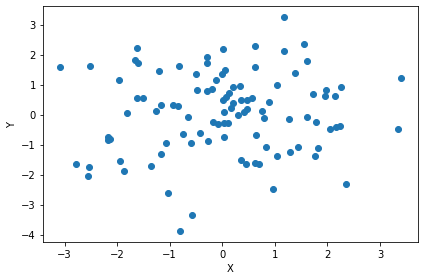

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(x, y)

# ax.set_xlim([-1,1.25])
# ax.set_ylim([-1,1.25])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.tight_layout()
plt.show()

In [38]:
V = 1 / np.sqrt(2) * np.array([[-1,1],[1,1]])
data = np.concatenate([x.reshape(1,-1),y.reshape(1,-1)], axis=0)

In [47]:
V = 1 / np.sqrt(2) * np.array([[-6,0],[0,1]])
data = np.concatenate([x.reshape(1,-1),y.reshape(1,-1)], axis=0)

In [48]:
tr = np.matmul(V, data)

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(tr[0,:], tr[1,:])

maxval = tr.max()
ax.set_xlim([-(maxval + 1), (maxval + 1)])
ax.set_ylim([-(maxval + 1), (maxval + 1)])
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [246]:
c = mean_eq_matrix_3(insects_list, df, "H1")
c.fillna('––').style.applymap(color_negative_red_2)

In [249]:
c = mean_eq_matrix_3_1(insects_list, df2, "H1")
c.fillna('––').style.applymap(color_negative_red_2)

In [73]:
_,_,_, cartesian1 = get_moved_coord(df, "Calliphora-vicina", 'M', 'H1')
cartesian1 = transform_cart_2("Calliphora-vicina", 'M', 'H1', cartesian1)
_,_,_, cartesian2 = get_moved_coord(df, "Calliphora-vicina", 'F', 'H1')
cartesian2 = transform_cart_2("Calliphora-vicina", 'F', 'H1', cartesian2)
plot_sph_distrs(cartesian1, cartesian2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
_,_,_, cartesian1 = get_moved_coord(df2, "Calliphora-vicina", 'M', 'H1')
cartesian1 = transform_cart_2("Calliphora-vicina", 'M', 'H1', cartesian1)
_,_,_, cartesian2 = get_moved_coord(df2, "Calliphora-vicina", 'F', 'H1')
cartesian2 = transform_cart_2("Calliphora-vicina", 'F', 'H1', cartesian2)
plot_sph_distrs(cartesian1, cartesian2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
_,_,_, cartesian1 = get_moved_coord(df, "Calliphora-vicina", 'M', 'H1')
cartesian1 = transform_cart_2("Calliphora-vicina", 'M', 'H1', cartesian1)
_,_,_, cartesian2 = get_moved_coord(df2, "Calliphora-vicina", 'M', 'H1')
cartesian2 = transform_cart_2("Calliphora-vicina", 'M', 'H1', cartesian2)
plot_sph_distrs(cartesian1, cartesian2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [75]:
_,_,_, cartesian1 = get_moved_coord(df2, "Calliphora-vicina", 'M', 'H1L')
# cartesian1 = transform_cart_2("Calliphora-vicina", 'M', 'H1', cartesian1)
plot_sph_distr(cartesian1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
cartesian1.shape

(11, 3)

In [76]:
# implementing bootstrapping methods
_,_,_, cartesian1 = get_moved_coord(df, "Calliphora-vicina", 'F', 'H1')
cartesian1 = transform_cart_2("Calliphora-vicina", 'F', 'H1', cartesian1)
_,_,_, cartesian12 = get_moved_coord(df2, "Calliphora-vicina", 'F', 'H1L')
cartesian12 = transform_cart_2("Calliphora-vicina", 'F', 'H1', cartesian12)
cartesian_1 = np.concatenate([cartesian1, cartesian12], axis=0)
# centre_of_mass1 = np.mean(cartesian_1, axis=0)

_,_,_, cartesian2 = get_moved_coord(df, "Calliphora-vicina", 'M', 'H1')
cartesian2 = transform_cart_2("Calliphora-vicina", 'M', 'H1', cartesian2)
_,_,_, cartesian22 = get_moved_coord(df2, "Calliphora-vicina", 'M', 'H1L')
cartesian22 = transform_cart_2("Calliphora-vicina", 'M', 'H1', cartesian22)
cartesian_2 = np.concatenate([cartesian2, cartesian22], axis=0)
# centre_of_mass2 = np.mean(cartesian_2, axis=0)
res_len, res_len1, res_len2, _, _, n = extract_resl_mresl_3(cartesian_1, cartesian_2)
g0, n1, n2, k1unb, k2unb = get_g(cartesian_1, cartesian_2)

# k1unb = (1 - 1/n1) * k1
# k2unb = (1 - 1/n2) * k2

In [45]:
plot_sph_distrs(cartesian_1,cartesian_2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [36]:
_,_,_, cartesian1 = get_moved_coord(df, "Calliphora-vicina", 'F', 'H1')
cartesian1 = transform_cart_2("Calliphora-vicina", 'F', 'H1', cartesian1)
_,_,_, cartesian12 = get_moved_coord(df2, "Calliphora-vicina", 'F', 'H1L')
cartesian12 = transform_cart_2("Calliphora-vicina", 'F', 'H1', cartesian12)
cartesian_1 = np.concatenate([cartesian1, cartesian12], axis=0)

In [ ]:
_,_,_, cartesian1 = get_moved_coord(df, "Tabanus-bromius", 'F', 'H1')
centre_of_mass1 = np.mean(cartesian1, axis=0)

_,_,_, cartesian2 = get_moved_coord(df, "Episyrphus-balteatus", 'M', 'H1')
centre_of_mass2 = np.mean(cartesian2, axis=0)
res_len, res_len1, res_len2, _, _, n = extract_resl_mresl_3(cartesian1, cartesian2)
g0, n1, n2, k1unb, k2unb = get_g(cartesian1, cartesian2)

In [46]:
plot_sph_distrs(cartesian1, cartesian2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
centre_of_mass1 = np.mean(cartesian1, axis=0)
centre_of_mass2 = np.mean(cartesian2, axis=0)
mean_dir1 = centre_of_mass1 / np.linalg.norm(centre_of_mass1)
mean_dir2 = centre_of_mass2 / np.linalg.norm(centre_of_mass2)
angle = np.arccos(mean_dir1@mean_dir2)
angle_deg = angle / np.pi * 180
angle_deg

8.18408901252128

In [55]:
# generate two Fisher distributions with a specified angle between means
cartesian1 = FisherDistribution(k1unb, n1)
cartesian2 = FisherDistribution(k2unb, n2)
centre_of_mass1 = np.mean(cartesian1, axis=0)
centre_of_mass2 = np.mean(cartesian2, axis=0)
azi1, ele1 = get_azi_ele(centre_of_mass1)
azi2, ele2 = get_azi_ele(centre_of_mass2)
# move to the center 
_,_, cartesian1 = get_azi_ele(cartesian1, azi=azi1, ele=ele1)
_,_, cartesian2 = get_azi_ele(cartesian2, azi=azi2, ele=ele2)
# move one away
_,_, cartesian1 = get_azi_ele(cartesian1, azi=0, ele=angle)
centre_of_mass1 = np.mean(cartesian1, axis=0)
centre_of_mass2 = np.mean(cartesian2, axis=0)
mean_dir1 = centre_of_mass1 / np.linalg.norm(centre_of_mass1)
mean_dir2 = centre_of_mass2 / np.linalg.norm(centre_of_mass2)
angle = np.arccos(mean_dir1@mean_dir2)
angle_deg = angle / np.pi * 180
angle_deg

8.184089012521236

In [56]:
k1unb, k2unb

(695.6192839804286, 157.99176317134172)

In [ ]:
# generate many pairs of samples with means at a specified angle and estimated k
# and test for equality of means
iters = 1000
pvals = np.zeros(iters)
for i in range(iters):
    cartesian1 = FisherDistribution(k1unb, n1)
    cartesian2 = FisherDistribution(k2unb, n2)
    centre_of_mass1 = np.mean(cartesian1, axis=0)
    centre_of_mass2 = np.mean(cartesian2, axis=0)
    azi1, ele1 = get_azi_ele(centre_of_mass1)
    azi2, ele2 = get_azi_ele(centre_of_mass2)
    # move to the center 
    _,_, cartesian1 = get_azi_ele(cartesian1, azi=azi1, ele=ele1)
    _,_, cartesian2 = get_azi_ele(cartesian2, azi=azi2, ele=ele2)
    # move one away
    _,_, cartesian1 = get_azi_ele(cartesian1, azi=0, ele=angle)
    res_len, res_len1, res_len2, _, _, n = extract_resl_mresl_3(cartesian1, cartesian2)
    Fval, crit, dof1, dof2 = high_k_Ftest_mardia(res_len, res_len1, res_len2, n)
    pvals[i] = round(1 - f.cdf(Fval, dof1, dof2), 3)
np.mean(pvals)

In [51]:
# generate many pairs of samples with the same mean and estimated k
# and test for equality of means
# also compute mean directions and check the simulated confidence cone
iters = 1000
pvals = np.zeros(iters)
angles = np.zeros(iters)
for i in range(iters):
    cartesian1 = FisherDistribution(k1unb, n1)
    cartesian2 = FisherDistribution(k2unb, n2)
    res_len, res_len1, res_len2, _, _, n = extract_resl_mresl_3(cartesian1, cartesian2)
    Fval, crit, dof1, dof2 = high_k_Ftest_mardia(res_len, res_len1, res_len2, n)
    pvals[i] = round(1 - f.cdf(Fval, dof1, dof2), 3)
    
    centre_of_mass1 = np.mean(cartesian1, axis=0)
    mean_dir1 = centre_of_mass1 / np.linalg.norm(centre_of_mass1)
    angles[i] = np.arccos(np.array([0,0,1])@mean_dir1)
pvals = np.sort(pvals)
angles = np.sort(angles)
np.mean(pvals)

0.496438

In [59]:
angles[-50:] / np.pi * 180

array([2.34575998, 2.35030975, 2.35202663, 2.35430632, 2.3570219 ,
       2.3694595 , 2.37505807, 2.37571975, 2.38677321, 2.39268951,
       2.39752998, 2.39811096, 2.40038391, 2.40395208, 2.40619157,
       2.41385024, 2.4156563 , 2.41979358, 2.42218091, 2.43022216,
       2.43660066, 2.44599301, 2.4619723 , 2.46292455, 2.47035212,
       2.48992833, 2.51215289, 2.51721825, 2.54365763, 2.62075422,
       2.63799707, 2.65675264, 2.68159065, 2.68691711, 2.68700023,
       2.693739  , 2.88184352, 2.88353898, 2.88576417, 2.90589345,
       2.96723439, 3.04204434, 3.06206029, 3.16210563, 3.16835391,
       3.24606846, 3.40479836, 3.42829561, 3.49794204, 3.75981244])

In [60]:
# generate many pairs of samples with the same mean and estimated k
# get test statistics g and compare with the g0 from actual data
# if g0 extreme enough - reject H0 based on bootstrap
iters = 1000
gs = np.zeros(iters)
for i in range(iters):
    cartesian1 = FisherDistribution(k1unb, n1)
    cartesian2 = FisherDistribution(k2unb, n2)
    gs[i],_,_,_,_ = get_g(cartesian1, cartesian2)
    
gs_sort = np.sort(gs)
geq = gs_sort[(gs_sort - g0) >= 0][0]
# largest index whose value is still smaller than g0
idx = np.where(gs_sort == geq)[0][0] - 1
pval = (iters - idx) / iters
pval

0.088

In [55]:
gs_sort[-5:]

array([10.92466526, 11.25717066, 12.02995728, 12.39883212, 13.00409824])

In [56]:
g0

18.608159024097404

In [13]:
# adjust observed pvalue to the nominal expected pvalue
# this prevents excessive rejections of H0
# not sure how reliable is this method is
epochs = 500
es = np.zeros(epochs)
significances = np.zeros(epochs)
for epoch in range(epochs):
    gs = np.zeros(iters)
    for i in range(iters):
        cartesian1 = FisherDistribution(k1unb, n1)
        cartesian2 = FisherDistribution(k2unb, n2)
        gs[i],_,_,_,_ = get_g(cartesian1, cartesian2)
    gs_sort = np.sort(gs)
    geq = gs_sort[(gs_sort - g0) >= 0][0]
    # largest index whose value is still smaller than g0
    idx = np.where(gs_sort == geq)[0][0] - 1
    significances[epoch] = (iters - idx) / iters
    es[epoch] = (epoch + 0.5) / epochs
significances_sort = np.sort(significances)

In [ ]:
significances = significance.reshape(1,-1)
es = es.reshape(1,-1)

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(es, significances_sort)

# maxval = tr.max()
# ax.set_xlim([-(maxval + 1), (maxval + 1)])
# ax.set_ylim([-(maxval + 1), (maxval + 1)])
ax.set_xlabel('Nominal pval')
ax.set_ylabel('Observed pval')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [37]:
# generate many Fisher distributions with the same parameters
# and see how the mean directions may differ
# also see how many rejects of equality
# we're looking at angle between means and not from means to the north pole
iters = 1000
angles = np.zeros(iters)
pvals = np.zeros(iters)
for i in range(iters):
    cartesian1 = FisherDistribution(50, 10)
    cartesian2 = FisherDistribution(50, 10)
    centre_of_mass1 = np.mean(cartesian1, axis=0)
    centre_of_mass2 = np.mean(cartesian2, axis=0)
    res_len, res_len1, res_len2, _, _, n = extract_resl_mresl_3(cartesian1, cartesian2)
    Fval, crit, dof1, dof2 = high_k_Ftest_mardia(res_len, res_len1, res_len2, n)
    pvals[i] = round(1 - f.cdf(Fval, dof1, dof2), 3)
    mean_dir1 = centre_of_mass1 / np.linalg.norm(centre_of_mass1)
    mean_dir2 = centre_of_mass2 / np.linalg.norm(centre_of_mass2)
    angles[i] = np.arccos(mean_dir1@mean_dir2)
#     angle_deg = angle / np.pi * 180
angles = np.sort(angles)
pvals = np.sort(pvals)

In [38]:
signif = 0.95
idx = round(len(angles)*signif)
angles[idx:] / np.pi * 180

array([ 8.99280044,  9.05380038,  9.0768557 ,  9.10162558,  9.11725852,
        9.19122526,  9.21844844,  9.24166636,  9.24381459,  9.25970487,
        9.2950178 ,  9.30625404,  9.31421816,  9.47447789,  9.49656537,
        9.4989306 ,  9.5325912 ,  9.5460922 ,  9.57678636,  9.58122384,
        9.58132306,  9.58804556,  9.69316574,  9.70062279,  9.77838841,
        9.79938502,  9.97396963,  9.9897326 , 10.00828936, 10.01174445,
       10.04266178, 10.06786903, 10.12522813, 10.26212754, 10.31476634,
       10.47940914, 10.68842267, 10.95858338, 11.01909739, 11.09810577,
       11.19435498, 11.22526273, 11.24420958, 11.26699718, 11.33082239,
       11.62636342, 11.73584435, 11.91702467, 13.47162679, 14.83222935])

In [41]:
pvals[:55]

array([0.001, 0.002, 0.002, 0.003, 0.004, 0.006, 0.007, 0.007, 0.008,
       0.01 , 0.01 , 0.011, 0.012, 0.014, 0.014, 0.015, 0.017, 0.018,
       0.02 , 0.02 , 0.02 , 0.021, 0.021, 0.022, 0.023, 0.025, 0.025,
       0.027, 0.027, 0.027, 0.028, 0.029, 0.03 , 0.031, 0.031, 0.031,
       0.033, 0.035, 0.035, 0.038, 0.039, 0.039, 0.041, 0.042, 0.045,
       0.045, 0.045, 0.046, 0.047, 0.048, 0.048, 0.048, 0.048, 0.048,
       0.048])

In [14]:
# see how many rejects we get when testing 2 distributions 9 degrees apart
# more than a half has pvalue more than 0.05
# that means that the test is not sensitive enough and fails to reject H0 too often
iters = 1000
pvals = np.zeros(iters)
angle = 0.16
for i in range(iters):
    cartesian1 = FisherDistribution(50, 10)
    cartesian2 = FisherDistribution(50, 10)
    centre_of_mass1 = np.mean(cartesian1, axis=0)
    centre_of_mass2 = np.mean(cartesian2, axis=0)
    azi1, ele1 = get_azi_ele(centre_of_mass1)
    azi2, ele2 = get_azi_ele(centre_of_mass2)
    # move to the center 
    _,_, cartesian1 = get_azi_ele(cartesian1, azi=azi1, ele=ele1)
    _,_, cartesian2 = get_azi_ele(cartesian2, azi=azi2, ele=ele2)
    # move one away
    _,_, cartesian1 = get_azi_ele(cartesian1, azi=0, ele=angle)
    res_len, res_len1, res_len2, _, _, n = extract_resl_mresl_3(cartesian1, cartesian2)
    Fval, crit, dof1, dof2 = high_k_Ftest_mardia(res_len, res_len1, res_len2, n)
    pvals[i] = round(1 - f.cdf(Fval, dof1, dof2), 3)
# np.mean(pvals)

In [ ]:
sorted(pvals)[-500:]

In [24]:
np.mean(pvals)

0.06001600000000001

In [17]:
# when estimates of k are close to their true values the bootstrap method gives
# similar results to repeated equality of means testing
cartesian1 = FisherDistribution(50, 10)
cartesian2 = FisherDistribution(50, 10)
centre_of_mass1 = np.mean(cartesian1, axis=0)
centre_of_mass2 = np.mean(cartesian2, axis=0)
azi1, ele1 = get_azi_ele(centre_of_mass1)
azi2, ele2 = get_azi_ele(centre_of_mass2)
# move to the center 
_,_, cartesian1 = get_azi_ele(cartesian1, azi=azi1, ele=ele1)
_,_, cartesian2 = get_azi_ele(cartesian2, azi=azi2, ele=ele2)
# move one away
_,_, cartesian1 = get_azi_ele(cartesian1, azi=0, ele=angle)
g0, n1, n2, k1unb, k2unb = get_g(cartesian1, cartesian2)

# bootstrap
iters = 1000
gs = np.zeros(iters)
for i in range(iters):
    cartesian1 = FisherDistribution(k1unb, n1)
    cartesian2 = FisherDistribution(k2unb, n2)
    gs[i],_,_,_,_ = get_g(cartesian1, cartesian2)
    
gs_sort = np.sort(gs)
geq = gs_sort[(gs_sort - g0) >= 0][0]
# largest index whose value is still smaller than g0
idx = np.where(gs_sort == geq)[0][0] - 1
pval = (iters - idx) / iters
pval

0.053

In [88]:
# cartesian1 = FisherDistribution(50, 10)
_,_,_, cartesian1 = get_moved_coord(df, "Tabanus-bromius", 'F', 'H1')

_,_,_, cartesian2 = get_moved_coord(df, "Episyrphus-balteatus", 'M', 'H1')

n1 = cartesian1.shape[0]

res1 = np.sum(cartesian1,axis=0)
reslen1 = np.linalg.norm(res1)
meandir1 = res1 / reslen1
mean_res_len1 = reslen1 / n1
k = n1 / (n1 - reslen1)
# if n1 >= 16:
k1 = (1 - 1/n1) * k
    # when mean_res_len < 0.95 and n < 16
    # Fisher eqn 5.26
k2 = (1 - 1/n1)**2 * k

In [89]:
k,k1,k2,mean_res_len1

(1086.9051312194194, 869.5241049755356, 695.6192839804286, 0.9990799565010076)

In [20]:
alpha = 0.01
semi_vert_angle = np.arccos(1 - (n1 - res_len1)/res_len1 * ((1/alpha)**(1/(n1 - 1)) - 1))
semi_vert_angle / np.pi * 180

3.616342116824744

In [28]:
alpha = 0.01
k_low = 0.5 * chi2.ppf(0.5 * alpha, 2 * n1 - 2) / (n1 - res_len1)
k_up = 0.5 * chi2.ppf(1 - 0.5 * alpha, 2 * n1 - 2) / (n1 - res_len1)
k_low, k_up

(146.12494827549367, 2386.2953235039245)

In [29]:
alpha = 0.01
k_low = 0.5 * chi2.ppf(0.5 * alpha, 2 * n2 - 2) / (n2 - res_len2)
k_up = 0.5 * chi2.ppf(1 - 0.5 * alpha, 2 * n2 - 2) / (n2 - res_len2)
k_low, k_up

(23.724281109395115, 651.1923393181885)

In [38]:
def JH_KvD(XYUV):
    T0 = R0 = [1,0,0]
    it_num = 20  # number of iteration
    nXYUV = np.shape(XYUV)[0]
    d_cart2D = XYUV[:,0:2]
    d_cart3D = pol2cart_3D(d_cart2D[:,0],d_cart2D[:,1],1)
    d_cart3D = np.transpose(d_cart3D)
    p_cart2D = XYUV[:,2:4] 
    p_cart3D = np.zeros_like(d_cart3D)
    for i in range(nXYUV):
        d = d_cart3D[i]
        u_hat = np.cross(d,[0,0,1]) / np.linalg.norm(np.cross(d,[0,0,1]))
        v_hat = np.cross(u_hat,d) / np.linalg.norm(np.cross(u_hat,d))
        p_cart3D[i,:] = u_hat * p_cart2D[i,0] + v_hat * p_cart2D[i,1]
    R_arr = T_arr = np.zeros(shape=(0,3))
    for iteration in range(it_num):  # <<<============== start of iteration
        R_arr = np.append(R_arr,[R0],axis=0)
        T_arr = np.append(T_arr,[T0],axis=0)
        d_num = p_sum = d_sum = pxd_sum = delta_sum = 0
        for i in range(nXYUV):
            d = d_cart3D[i,:]
            p = p_cart3D[i,:]
            d_num += 1
            p_sum += p
            d_sum += d
            pxd_sum += np.cross(p,d)
            delta_sum += (np.eye(3) - np.outer(d,d))
        p_mean = p_sum / d_num
        d_mean = d_sum / d_num
        pxd_mean = pxd_sum / d_num
        delta_mean = np.linalg.inv(delta_sum / d_num)  #<<< 3x3 matrix
        R1=np.dot(delta_mean, pxd_mean + np.cross(T0,d_mean))
        T1=np.dot(delta_mean, - p_mean - np.cross(R0,d_mean))
        R0=R1
        T0=T1
    R_arr_pol = cart2pol_3D(R_arr[:,0],R_arr[:,1],R_arr[:,2])
    T_arr_pol = cart2pol_3D(T_arr[:,0],T_arr[:,1],T_arr[:,2])
    R_arr_pol = np.transpose(R_arr_pol)
    T_arr_pol = np.transpose(T_arr_pol)
    return R_arr_pol[len(R_arr_pol)-1], T_arr_pol[len(T_arr_pol)-1]

In [46]:
def JH_Kabsch(XYUV):

    XYUV_raw=np.zeros(shape=(0,3))
    XYUV_new=np.zeros(shape=(0,3))

    for i in range(len(XYUV)):
        vec=pol2cart_3D(XYUV[i,0],XYUV[i,1],1)
        XYUV_raw=np.append(XYUV_raw, [vec], axis=0)

        vec_new=pol2cart_3D(XYUV[i,0]+XYUV[i,2],XYUV[i,1]+XYUV[i,3],1)
        XYUV_new=np.append(XYUV_new, [vec_new], axis=0)

    mestimated_rotation , _ = R.align_vectors(XYUV_raw,XYUV_new)

    mx = mestimated_rotation.as_rotvec()
    rotvec=cart2pol_3D(mx[0], mx[1], mx[2])
    azi_rot=rotvec[0]
    ele_rot=rotvec[1]

    return [azi_rot,ele_rot]

In [44]:
def cart2pol_3D(x,y,z):
    r = np.sqrt(x**2+y**2+z**2)
    azi = -np.arctan2(y,x)
    ele = np.arcsin(z/r)
    return np.rad2deg(azi),np.rad2deg(ele),r

def pol2cart_3D(azi_deg, ele_deg, rho):
    x = rho * np.cos(np.deg2rad(ele_deg)) * np.cos(np.deg2rad(-azi_deg))
    y = rho * np.cos(np.deg2rad(ele_deg)) * np.sin(np.deg2rad(-azi_deg)) 
    z = rho * np.sin(np.deg2rad(ele_deg)) 
    return x, y, z

In [42]:
def get_motion_axes(filelist, quiver_scale=5):

    XYUV_arr=np.zeros(shape=(0,84,4))
    for n in range(len(filelist)):
        fn=filelist[n]
        # print(fn)

        file = file_path + '/' + fn 
        XYUV = sio.loadmat(file)['XYUV']
        idx=np.lexsort((XYUV[:,1],XYUV[:,0]),axis=0)
        XYUV_sort=XYUV[idx]
        XYUV_arr=np.append(XYUV_arr, [XYUV_sort],axis=0)

    XYUV_mean=np.mean(XYUV_arr,axis=0)
    for i in range(len(XYUV_mean)):
        if XYUV_mean[i,0]==-180:
            XYUV_mean=np.append(XYUV_mean,[[180,XYUV_mean[i,1],XYUV_mean[i,2],XYUV_mean[i,3]]],axis=0)

    XYUV_mean[:,2] = -XYUV_mean[:,2]
    XYUV_mean[:,3] = -XYUV_mean[:,3]
    X=XYUV_mean[:,0]
    Y=XYUV_mean[:,1]
    U=XYUV_mean[:,2]
    V=XYUV_mean[:,3]

    iX,iY = np.meshgrid(np.arange(-180,181,15),np.arange(-75,76,15))
    # iU = np.zeros_like(iX,dtype=np.float64)
    # iV = np.zeros_like(iY,dtype=np.float64)
    iU = interpolate.griddata((X,Y),U,(iX,iY),method='linear')
    iV = interpolate.griddata((X,Y),V,(iX,iY),method='linear')

    fig=plt.figure(num=None, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k')
    plt.quiver(iX,iY,iU,iV,scale=quiver_scale,units='xy',color='grey',width=1,headwidth=2,headlength=4) 
    plt.quiver(X,Y,U,V,scale=quiver_scale,units='xy',color='k',width=1,headwidth=2,headlength=4)   
    ax=plt.gca()
    plt.xlabel("Azimuth (deg)",fontsize=24)
    plt.ylabel("Elevation (deg)",fontsize=24)
    Az_ticks = np.arange(-180, 181, 30)  
    ax.set_xticks(Az_ticks) 
    Az_minor_ticks = np.arange(-180, 181, 15)  
    ax.set_xticks(Az_minor_ticks, minor=1)
    El_ticks = np.arange(-75, 76, 30)  
    ax.set_yticks(El_ticks) 
    El_minor_ticks = np.arange(-75, 76, 15)  
    ax.set_yticks(El_minor_ticks, minor=1)  
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    ax.set_aspect(1)


    KvD_R,KvD_T=JH_KvD(XYUV_mean)#;print('KvD_R=',KvD_R,'KvD_T=',KvD_T)
    Kabsch_R=JH_Kabsch(XYUV_mean)#;print('Kabsch_R=',Kabsch_R

    print(filelist[0].split('_M_')[0], ', N=', len(filelist))
    print('Kabsch_R=',np.round(Kabsch_R))
    print('KvD_R=',np.round(KvD_R[0:2]))
    print('KvD_T=',np.round(KvD_T[0:2]))
    

In [40]:
import os
import scipy.io as sio
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.transform import Rotation as R
from scipy import interpolate

In [ ]:
file_path='/Users/nikitazabolotniy/Desktop/FWDmodel/[quiver_th]Clement_Blowfly_2018-08-03_F_c2r1[H1L]'
filelist=[x for x in os.listdir(file_path) if '.mat' in x]

print('<<< input >>>')
print('\n'.join(filelist))
print(' ')
print('<<< output >>>')

quiver_scale = 8
subfilelist=[]
for n in range(len(filelist)):
    # print(filelist[n],filelist[n].split('_M_')[0])
    # print(subfilelist)

    if subfilelist==[] :
        subfilelist.append(filelist[n])

    elif ( filelist[n].split('_M_')[0] == subfilelist[0].split('_M_')[0]):
        subfilelist.append(filelist[n])

    elif ( filelist[n].split('_M_')[0] != subfilelist[0].split('_M_')[0]):
        print(subfilelist)  #<<< debug
        get_motion_axes(filelist=subfilelist, quiver_scale=quiver_scale)
        subfilelist=[]
        subfilelist.append(filelist[n])

    if n == len(filelist)-1:
        print(subfilelist)  #<<< debug
        get_motion_axes(filelist=subfilelist, quiver_scale=quiver_scale)

In [98]:
XYUV_arr=np.zeros(shape=(0,84,4))
filelist = subfilelist
quiver_scale = 8
for n in range(len(filelist)):
    fn=filelist[n]
    # print(fn)

    file = file_path + '/' + fn 
    XYUV = sio.loadmat(file)['XYUV']
    idx=np.lexsort((XYUV[:,1],XYUV[:,0]),axis=0)
    XYUV_sort=XYUV[idx]
    XYUV_arr=np.append(XYUV_arr, [XYUV_sort],axis=0)

XYUV_mean=np.mean(XYUV_arr,axis=0)
for i in range(len(XYUV_mean)):
    if XYUV_mean[i,0]==-180:
        XYUV_mean=np.append(XYUV_mean,[[180,XYUV_mean[i,1],XYUV_mean[i,2],XYUV_mean[i,3]]],axis=0)
        
XYUV_mean[:,2] = -XYUV_mean[:,2]
XYUV_mean[:,3] = -XYUV_mean[:,3]

In [99]:
XYUV_mean_flip = XYUV_mean.copy()
data_pts = XYUV_mean.shape[0]
run = True
row_n = 0
while(run):
    azi_val = XYUV_mean_flip[row_n,0]
    n_matches = np.sum(azi_val == XYUV_mean_flip[row_n:row_n+4,0])
    if n_matches == 4:
        XYUV_mean_flip_seg = XYUV_mean_flip[row_n:row_n + 4, :]
        XYUV_mean_seg = XYUV_mean[data_pts - row_n - 4:data_pts - row_n, :]
        XYUV_mean_flip_seg[:,2] = -XYUV_mean_seg[:,2]
        XYUV_mean_flip_seg[:,3] = XYUV_mean_seg[:,3]
        XYUV_mean_flip[row_n:row_n+4,:] = XYUV_mean_flip_seg
        row_n += 4
    else:
        XYUV_mean_flip_seg = XYUV_mean_flip[row_n:row_n + 2, :]
        XYUV_mean_seg = XYUV_mean[data_pts - row_n - 2:data_pts - row_n, :]
        XYUV_mean_flip_seg[:,2] = -XYUV_mean_seg[:,2]
        XYUV_mean_flip_seg[:,3] = XYUV_mean_seg[:,3]
        XYUV_mean_flip[row_n:row_n + 2,:] = XYUV_mean_flip_seg
        row_n += 2
    if XYUV_mean_flip_seg[0,0] == 180:
        run = False

In [100]:
JH_KvD(XYUV_mean)

(array([-40.80474766,  79.33905304,  65.12999447]),
 array([-129.27060141,   17.0351516 ,   33.90946682]))

In [101]:
JH_KvD(XYUV_mean_flip)

(array([-139.19525234,  -79.33905304,   65.12999447]),
 array([129.27060141,  17.0351516 ,  33.90946682]))

In [83]:
_,_,_, cartesian = get_moved_coord(df, "Calliphora-vicina", 'F', 'H1')
polar = Cart2Polar(cartesian.T).T
# flip azimuth
polar[1,1] = -polar[1,1]
x = np.sin(polar[:,0]) * np.cos(polar[:,1]).reshape(1,-1)
y = np.sin(polar[:,0]) * np.sin(polar[:,1]).reshape(1,-1)
z = np.cos(polar[:,0]).reshape(1,-1)
cartesian = np.concatenate([x,y,z], axis=0).T
# reverse vector direction
cartesian[1,:] = -cartesian[1,:] 
centre_of_massF = np.mean(cartesian, axis=0)

In [88]:
_,_,_, cartesian = get_moved_coord(df, "Calliphora-vicina", 'F', 'H1')
polar = Cart2Polar(cartesian.T).T

In [86]:
polar = Cart2Polar(cartesian.T).T

In [111]:
cart1 = np.array(pol2cart_3D(-40.80474766,  79.33905304, 1))

In [112]:
polar = Cart2Polar(cart1.T).T
# flip azimuth
polar[1,1] = -polar[1,1]
x = np.sin(polar[:,0]) * np.cos(polar[:,1]).reshape(1,-1)
y = np.sin(polar[:,0]) * np.sin(polar[:,1]).reshape(1,-1)
z = np.cos(polar[:,0]).reshape(1,-1)
cartesian = np.concatenate([x,y,z], axis=0).T
# reverse vector direction
cartesian[1,:] = -cartesian[1,:]

IndexError: too many indices for array

In [117]:
polar = Cart2Polar(cart1.T).T
# flip azimuth
polar[1] = -polar[1]
x = np.sin(polar[0]) * np.cos(polar[1]).reshape(1,-1)
y = np.sin(polar[0]) * np.sin(polar[1]).reshape(1,-1)
z = np.cos(polar[0]).reshape(1,-1)
cartesian = np.concatenate([x,y,z], axis=0).T
# reverse vector direction
cartesian = -cartesian

In [120]:
cartesian

array([[-0.14003166,  0.12089234, -0.98273912]])

In [121]:
Cart2Polar(cartesian.T).T / np.pi * 180

array([[169.33905304, 139.19525234]])